This example shows how to use `segmentation-models-pytorch` for **binary** semantic segmentation of lane lines. It is based on binary segmentation examples from `segmentation-models-pytorch` found here:
 

*    https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/binary_segmentation_intro.ipynb
*   https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb.

I used the TuSimple dataset found here: https://github.com/TuSimple/tusimple-benchmark/issues/3

see 'create_lane_data.py' for label creation

In [2]:
!pip install segmentation-models-pytorch
!pip install pytorch-lightning==1.5.4

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print(os.getcwd())
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

from pprint import pprint
from torch.utils.data import DataLoader



/home/boatlanding


## Dataset

Dataset created based on the TuSimple dataset

1.   **Images** 🖼  
    ✅   Images from dataset have **the same size**, required for packing images to a batch.  
    ✅   Images height and width are **divisible by 32**. This step is important for segmentation, because almost all models have skip-connections between encoder and decoder and all encoders have 5 downsampling stages (2 ^ 5 = 32). Very likely you will face with error when model will try to concatenate encoder and decoder features if height or width is not divisible by 32.  
    ✅   Images have **correct axes order**. PyTorch works with CHW order, we read images in HWC [height, width, channels], don`t forget to transpose image.
2.   **Masks** 🔳  
    ✅   Masks have **the same sizes** as images.   
    ✅   Masks have only `0` - lanes and `1` - background (for binary segmentation).  
    ✅   Even if mask don`t have channels, you need it. Convert each mask from **HW to 1HW** format for binary segmentation (expand the first dimension).

Some of these checks are included in LightningModule below during the training.

❗️ And the main rule: your train, validation and test sets are not intersects with each other!

In [3]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import cv2
import numpy as np
import pdb

In [4]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        # pdb.set_trace()
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [5]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['lane', 'road']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        # pdb.set_trace()
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

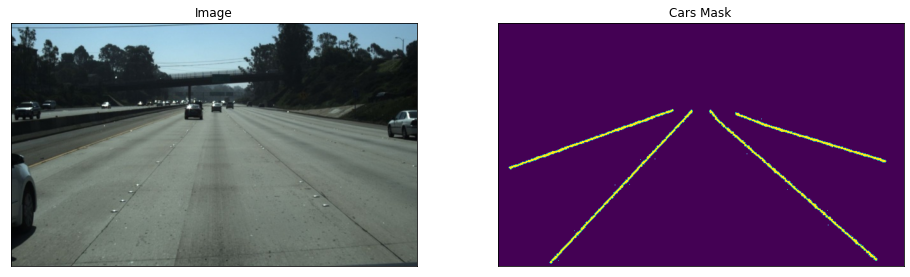

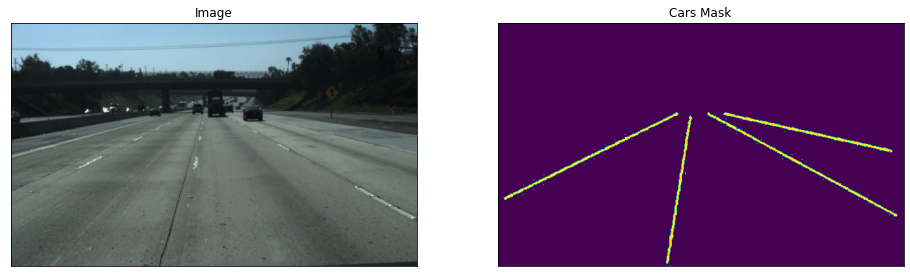

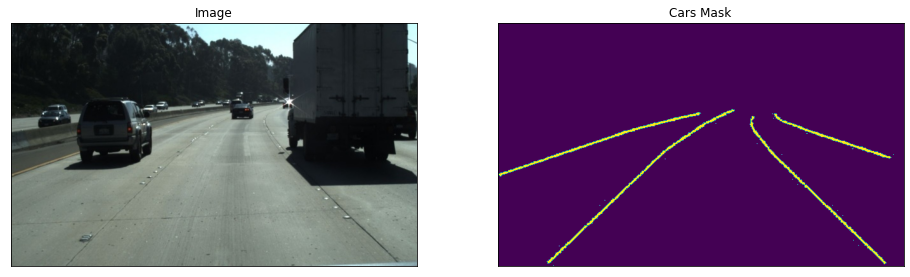

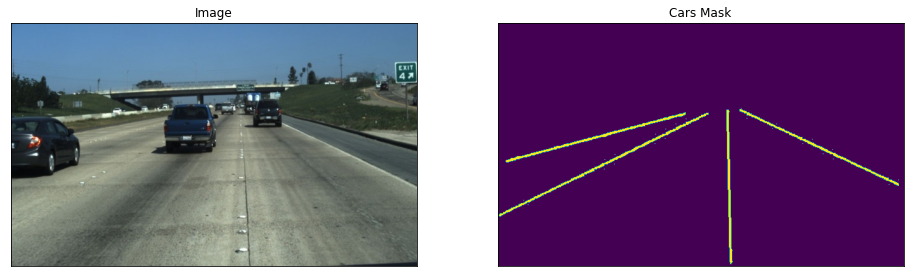

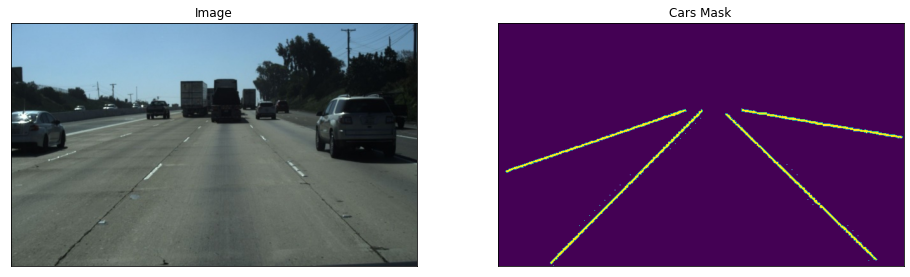

In [6]:
# Lets look at data we have
x_train_dir = "./datasets/tusimple/train/pic"
y_train_dir = "./datasets/tusimple/train/label"
x_valid_dir = "./datasets/tusimple/val/pic"
y_valid_dir = "./datasets/tusimple/val/label"
dataset = Dataset(x_train_dir, y_train_dir, classes=['lane'])
# pdb.set_trace()
for i in range(5):
  image, mask = dataset[i] # get some sample
  visualize(
      image=image, 
      cars_mask=mask.squeeze(),
  )

# Data Augment

In [9]:
# Install required libs
!pip install -U segmentation-models-pytorch --user #albumentations --user 
!pip install -U albumentations[imgaug] --user
import albumentations as albu

Requirement already up-to-date: segmentation-models-pytorch in ./.local/lib/python3.8/site-packages (0.2.1)
Requirement already up-to-date: albumentations[imgaug] in ./.local/lib/python3.8/site-packages (1.1.0)


In [7]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.augmentations.transforms.GaussNoise(p=0.2),
        albu.augmentations.geometric.transforms.Perspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.augmentations.transforms.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

/home/boatlanding/.local/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1800: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/boatlanding/.local/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1826: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


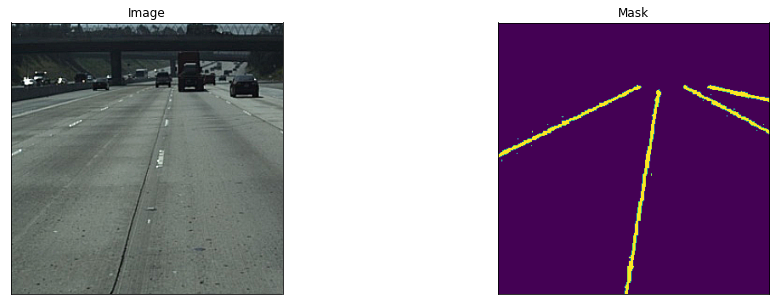

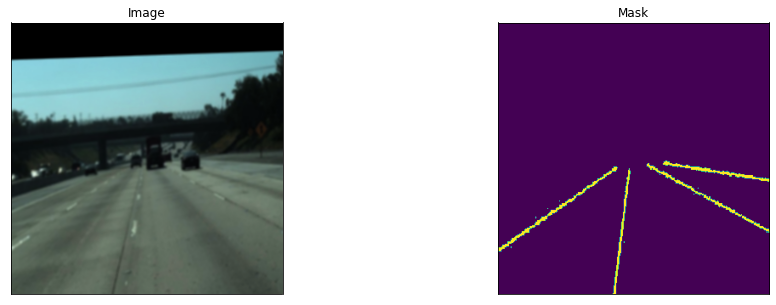

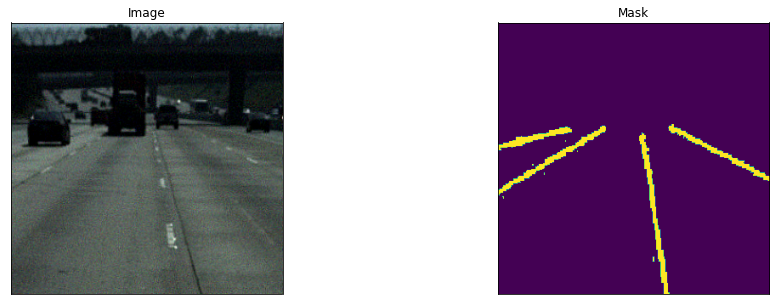

In [10]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['lane'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze(-1))

  # for i in range(5):
  #   image, mask = dataset[i] # get some sample
  #   visualize(
  #       image=image, 
  #       cars_mask=mask.squeeze(),
  #   )

## Model

In [15]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['lane']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [16]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

/home/boatlanding/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Training

In [13]:


# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])



In [14]:


# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
DEVICE = 'cuda'
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)



In [15]:
# train model for 40 epochs

max_score = 0

for i in range(0, 200):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 150:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|                                                       | 0/386 [00:00<?, ?it/s]

/home/boatlanding/.local/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


valid: 100%|█████| 358/358 [00:36<00:00,  9.86it/s, dice_loss - 0.4738, iou_score - 0.3675]
Model saved!

Epoch: 1
valid: 100%|█████| 358/358 [00:35<00:00, 10.06it/s, dice_loss - 0.4353, iou_score - 0.4033]
Model saved!

Epoch: 2
valid: 100%|█████| 358/358 [00:35<00:00, 10.17it/s, dice_loss - 0.4313, iou_score - 0.4058]
Model saved!

Epoch: 3
valid: 100%|█████| 358/358 [00:35<00:00, 10.15it/s, dice_loss - 0.4286, iou_score - 0.4073]
Model saved!

Epoch: 4
valid: 100%|█████| 358/358 [00:35<00:00, 10.16it/s, dice_loss - 0.4388, iou_score - 0.3949]

Epoch: 5
valid: 100%|█████| 358/358 [00:35<00:00, 10.15it/s, dice_loss - 0.4375, iou_score - 0.3965]

Epoch: 6
valid: 100%|█████| 358/358 [00:35<00:00, 10.16it/s, dice_loss - 0.4109, iou_score - 0.4256]
Model saved!

Epoch: 7
valid: 100%|█████| 358/358 [00:35<00:00, 10.14it/s, dice_loss - 0.4165, iou_score - 0.4187]

Epoch: 8
valid: 100%|██████| 358/358 [00:35<00:00, 10.16it/s, dice_loss - 0.4034, iou_score - 0.433]
Model saved!

Epoch: 9
vali

KeyboardInterrupt: ignored

# Result visualization

In [11]:
# load best saved checkpoint
best_model = torch.load('./datasets/best_model.pth')

In [17]:
# create test dataset
test_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [18]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

NameError: ignored

In [20]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_valid_dir, y_valid_dir, 
    classes=CLASSES,
)

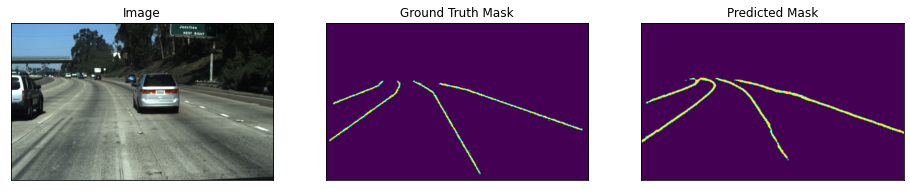

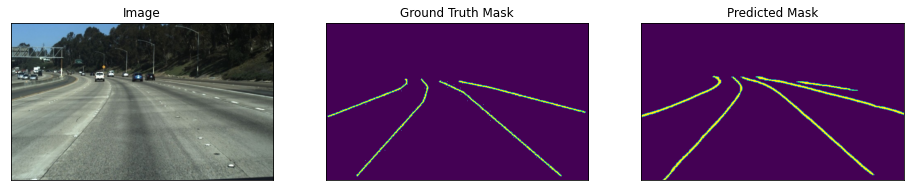

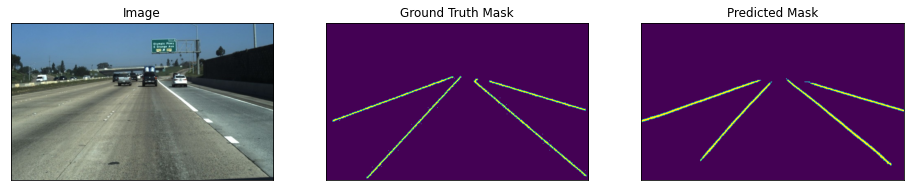

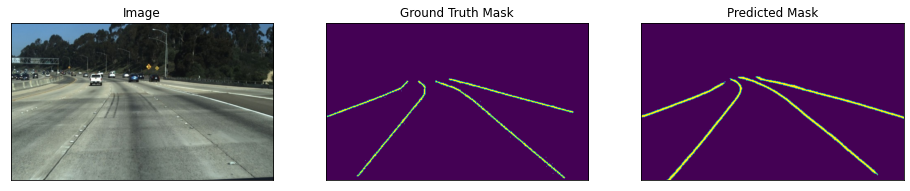

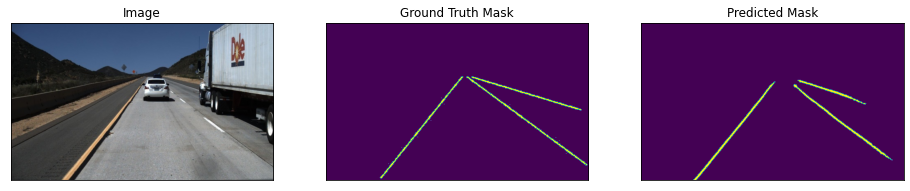

In [23]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # pdb.set_trace()
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

0.09736510000000001


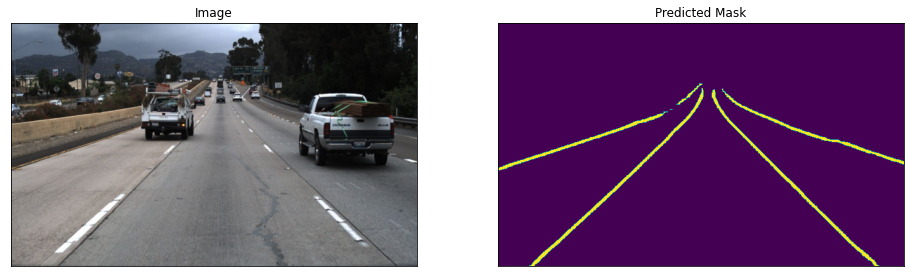

In [90]:
import time

# Predict on an image that must be resized
test_img = cv2.imread('./datasets/tusimple/val/pic2/1494453483612295927.jpg')


test_img = cv2.resize(test_img, (640,384))
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_tensor = test_img.reshape((3,384,640))

# Need to pre process the image same as valid and test
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
_transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor),
    ]
preprocess = albu.Compose(_transform)
sample = preprocess(image=test_img)
image = sample["image"]


x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

tic = time.time_ns()
pr_mask = best_model.predict(x_tensor)
pr_mask = (pr_mask.squeeze().cpu().numpy().round())
toc = time.time_ns()
print((toc-tic)*10**-9)

visualize(image=test_img, predicted_mask=pr_mask)

In [102]:


# Predict on an image that must be resized
video = cv2.VideoCapture("./Downloads/test.mp4")

frame = 0
while True:
    ret, img = video.read()

    if frame == 20:
      break

    if ret:
      test_img = cv2.resize(img, (640,384))
      test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
      test_tensor = test_img.reshape((3,384,640))

      # Need to pre process the image same as valid and test
      preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
      _transform = [
              albu.Lambda(image=preprocessing_fn),
              albu.Lambda(image=to_tensor),
          ]
      preprocess = albu.Compose(_transform)
      sample = preprocess(image=test_img)
      image = sample["image"]


      x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

      tic = time.time_ns()
      pr_mask = best_model.predict(x_tensor)
      pr_mask = (pr_mask.squeeze().cpu().numpy().round())
      toc = time.time_ns()
      print((toc-tic)*10**-9)
      frame+=1

      visualize(image=test_img, predicted_mask=pr_mask)
    else:
      break

['05081544_0305-003986.jpg', '05081544_0305-000593.jpg', '05081544_0305-004425.jpg', '05081544_0305-003282.jpg', '05081544_0305-005189.jpg', '05081544_0305-002062.jpg', '05081544_0305-004621.jpg', '05081544_0305-003208.jpg', '05081544_0305-003665.jpg', '05081544_0305-004907.jpg', '05081544_0305-000931.jpg', '05081544_0305-002083.jpg', '05081544_0305-000642.jpg', '05081544_0305-003971.jpg', '05081544_0305-003629.jpg', '05081544_0305-004972.jpg', '05081544_0305-005063.jpg', '05081544_0305-000479.jpg', '05081544_0305-004883.jpg', '05081544_0305-004053.jpg', '05081544_0305-001255.jpg', '05081544_0305-001466.jpg', '05081544_0305-002512.jpg', '05081544_0305-003054.jpg', '05081544_0305-004314.jpg', '05081544_0305-002508.jpg', '05081544_0305-000603.jpg', '05081544_0305-000540.jpg', '05081544_0305-004411.jpg', '05081544_0305-000720.jpg', '05081544_0305-003033.jpg', '05081544_0305-000669.jpg', '05081544_0305-003508.jpg', '05081544_0305-001447.jpg', '05081544_0305-001879.jpg', '05081544_0305-0051

/home/boatlanding/.local/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


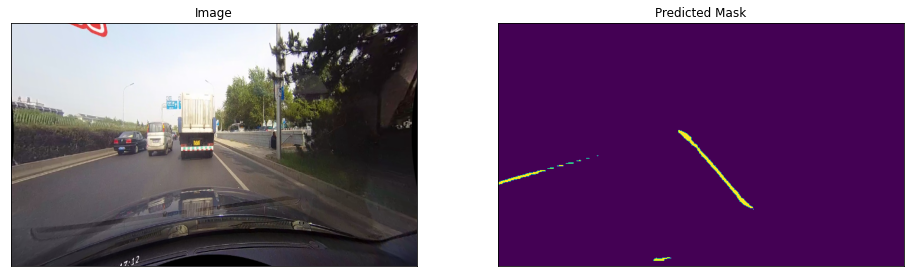

0.10764920800000001


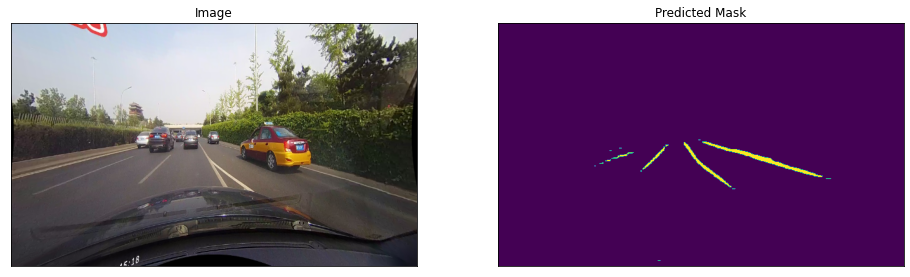

0.09728176100000001


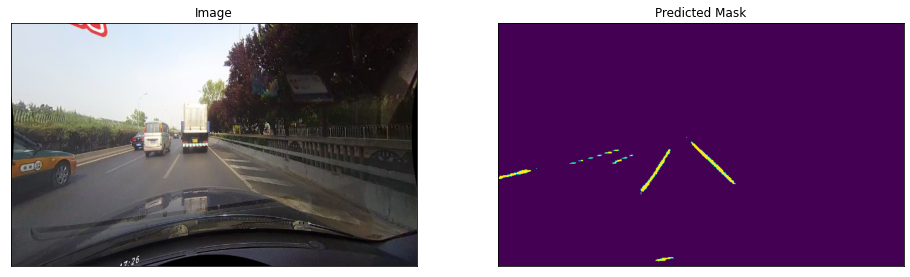

0.10840040100000001


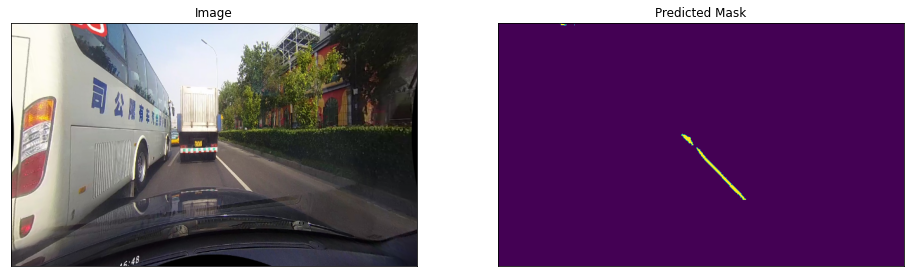

0.099424735


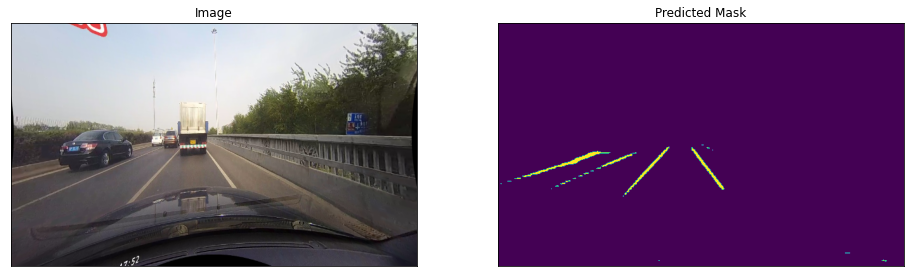

(590, 1640, 3)


In [110]:


# Predict on an image that must be resized
main_dir = "./Downloads/video_example/05081544_0305/"
files = os.listdir(main_dir)
print(files)
frame = 0
for file in files:
    img = cv2.imread(main_dir+file)

    if frame == 5:
      print(img.shape)
      break

    test_img = cv2.resize(img, (640,384))
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    test_tensor = test_img.reshape((3,384,640))

    # Need to pre process the image same as valid and test
    preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
    _transform = [
            albu.Lambda(image=preprocessing_fn),
            albu.Lambda(image=to_tensor),
        ]
    preprocess = albu.Compose(_transform)
    sample = preprocess(image=test_img)
    image = sample["image"]


    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

    tic = time.time_ns()
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    toc = time.time_ns()
    print((toc-tic)*10**-9)
    frame+=1

    visualize(image=test_img, predicted_mask=pr_mask)

In [121]:
print(torch.cuda.memory_allocated())
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())

577294336
577294336
